In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from keras.models import load_model
from PyFunctions import Viz

Using plaidml.keras.backend backend.


In [2]:
model_name = 'Normal1'
def get_pickles(pick_name):
    x_train, x_test, y_train, y_test, x_val, y_val = pickle.load(open(f'../Pickles/TTSMask_{pick_name}.p', 'rb'))
    return x_train, x_test, y_train, y_test, x_val, y_val

x_train, x_test, y_train, y_test, x_val, y_val  = get_pickles(model_name) 
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(10000, 150, 150, 3) (992, 150, 150, 3)
(10000, 2) (992, 2)


In [3]:
def get_conv_model(dim): 
    
    model = Sequential()
    model.add(Conv2D(100,(3,3), activation = 'relu', input_shape = dim))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(100, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dropout(.5))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(2, activation = 'sigmoid', name = 'Output'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model



In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=5, min_delta = .00075)
model_checkpoint = ModelCheckpoint(f'ModelWeights/Normal_Masks.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 10
    

dim = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
cnn = get_conv_model(dim =dim)

    
train_aug =ImageDataGenerator(rotation_range = 40, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
# augmentation.fit(x_train)
cnn_history = cnn.fit_generator(train_aug.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/2000
1000/1000 [==============================] - 69s 69ms/step - loss: 0.3306 - acc: 0.8697 - val_loss: 0.2323 - val_acc: 0.9148

Epoch 00001: val_loss improved from inf to 0.23231, saving model to ModelWeights/Normal_Masks.h5
Epoch 2/2000
1000/1000 [==============================] - 65s 65ms/step - loss: 0.2397 - acc: 0.9126 - val_loss: 0.1752 - val_acc: 0.9405

Epoch 00002: val_loss improved from 0.23231 to 0.17522, saving model to ModelWeights/Normal_Masks.h5
Epoch 3/2000
1000/1000 [==============================] - 64s 64ms/step - loss: 0.2183 - acc: 0.9171 - val_loss: 0.1448 - val_acc: 0.9531

Epoch 00003: val_loss improved from 0.17522 to 0.14478, saving model to ModelWeights/Normal_Masks.h5
Epoch 4/2000
1000/1000 [==============================] - 63s 63ms/step - loss: 0.2052 - acc: 0.9278 - val_loss: 0.1303 - val_acc: 0.9531

Epoch 00004: val_loss improved from 0.14478 to 0.13027, saving model to ModelWeights/Normal_Masks.h5
Epoch 5/2000
1000/1000 [====================

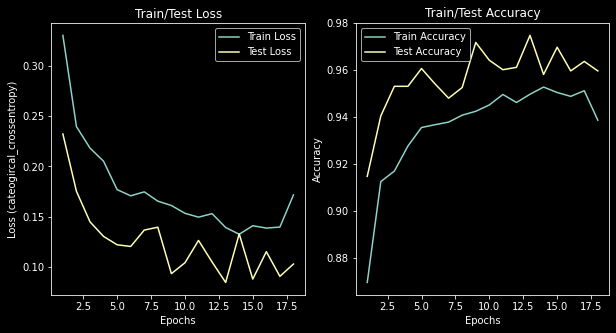

In [5]:
Viz.plot_loss_accuracy(cnn_history, 'dark_background')

F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\PyFunctions\Viz.py:138: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(tick_marks, classes)
F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\PyFunctions\Viz.py:139: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(tick_marks, classes)
F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\PyFunctions\Viz.py:158: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(tick_marks, classes)
F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\PyFunct

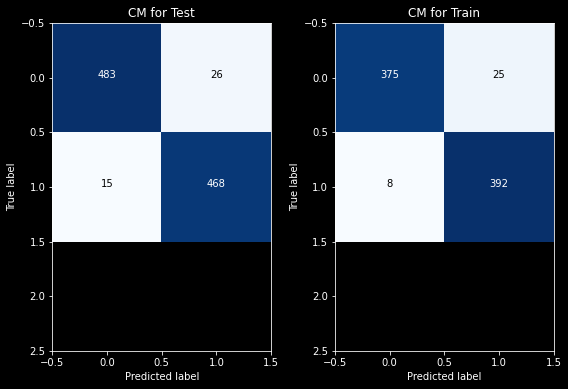

In [6]:
y_test_prob = [np.argmax(i) for i in cnn.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

val_prob = [np.argmax(i) for i in cnn.predict(x_val)]
val_labels = [np.argmax(i) for i in y_val]
val_cnf = confusion_matrix(val_labels, val_prob)

#this function creates a confusion matrix given the confusion matrixes of test and train
Viz.plot_model_cm(test_cnf, val_cnf, classes = ['No Mask', 'Mask'], theme = 'dark_background')